## Проект образовательной платформы

### Задание 1. A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.   

**_Входные данные:_**    

 - **_groups.csv_** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)  
 - **_groups_add.csv_** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных  
 - **_active_studs.csv_** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.   
 - **_checks.csv_** - файл с информацией об оплатах пользователей в дни проведения эксперимента.   
 
**Вопросы:**  
- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?  


**Загрузка данных и EDA**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
from scipy.stats import norm 
from scipy.stats import chi2_contingency, chi2 
import pingouin as pg

import requests
from urllib.parse import urlencode

%matplotlib inline
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(8, 4)}, style="whitegrid")

In [2]:
# Напишем функцию загрузки данных с диска

def load_data(public_key):
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Записываем результат в df
    df = pd.read_csv(download_url, sep=';')   # подходит только для ссылок 1 и 4
    
    return df

In [3]:
# links

public_key1 = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
public_key2 = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
public_key3 = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
public_key4 = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [4]:
# получим результат в датафреймы

groups = load_data(public_key1)
checks = load_data(public_key4)

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
# Получаем данные с яндекс диска (для ссылок 2 и 3)

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

final_url = base_url + urlencode(dict(public_key=public_key2)) 
group_add = pd.read_csv(requests.get(final_url).json()['href'])

final_url = base_url + urlencode(dict(public_key=public_key3)) 
activ_stud = pd.read_csv(requests.get(final_url).json()['href'])

In [6]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [8]:
activ_stud.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [9]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [10]:
# проверка типов данных, а также на присутствие дублей и пропущенных значений

data = [groups, group_add, activ_stud, checks]

def func_check(x):
    title_lst = ['groups', 'group_add', 'activ_stud', 'checks']
    for num, df in enumerate(x):
        a = df.shape[0]
        if df.duplicated().sum() == 0:
            b = 'дубли отсутствуют'
        else:
            b = 'дублей - ' + str(df.duplicated().sum())   
        с = df.isna().sum()
        
        print(f'\033[1m Датафрейм "{title_lst[num]}":\033[0m') 
        print(f'Проверка типов данных: \n{df.dtypes}')
        print()
        print(f'Количество строк в датафрейме \033[1m {title_lst[num]}: {a}\033[0m, {b}') 
        print(f'Количество уникальных значений: {df.nunique()[0]}')
        print()
        print(f'Проверяем количество нулевых значений - датафрейм {title_lst[num]}: \n{с}')
        print()
info = func_check(data)
info

 Датафрейм "groups":
Проверка типов данных: 
id      int64
grp    object
dtype: object

Количество строк в датафрейме  groups: 74484, дубли отсутствуют
Количество уникальных значений: 74484

Проверяем количество нулевых значений - датафрейм groups: 
id     0
grp    0
dtype: int64

 Датафрейм "group_add":
Проверка типов данных: 
id      int64
grp    object
dtype: object

Количество строк в датафрейме  group_add: 92, дубли отсутствуют
Количество уникальных значений: 92

Проверяем количество нулевых значений - датафрейм group_add: 
id     0
grp    0
dtype: int64

 Датафрейм "activ_stud":
Проверка типов данных: 
student_id    int64
dtype: object

Количество строк в датафрейме  activ_stud: 8341, дубли отсутствуют
Количество уникальных значений: 8341

Проверяем количество нулевых значений - датафрейм activ_stud: 
student_id    0
dtype: int64

 Датафрейм "checks":
Проверка типов данных: 
student_id      int64
rev           float64
dtype: object

Количество строк в датафрейме  checks: 541, дуб

Как видим, аномалий в данных никаких пока не наблюдается. Пустых значений и дублей тоже не было обнаружено.
При этом наблюдаем, что в файле активных пользователей, которые зашли на платформу в день проведения эксперимента - существенно меньше (8341 человек от общего числа пользователей 74484) и составляет примерно 10% от всех пользователей. А файл с оплатами пользователей в день эксперимента  - содержит еще меньшее количество пользователей - всего 541 оплативших пользователей.  

**Подготовка и преобразование данных**  

Далее нужно объединить данные: вначале присоединяем к основному датасету со списком всех пользователей - датасет, который получили на два дня позже. После этого полный список пользователей объединим с датасетом покупок, а потом также объединим датасет активных пользователей с данными о покупках. 

In [11]:
# добавим в первый датасет groups дополнительные данные второго group_add, создав новые значения индекса

groups_df = pd.concat([groups, group_add], ignore_index=True)

# переименовываем название колонки для дальнейшего удобства
groups_df = groups_df.rename(columns={'id':'student_id'})   

groups_df.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [12]:
# проведем проверку по полученному количеству

if (groups.shape[0] + group_add.shape[0]) == groups_df.shape[0]:
    print('все верно')
else:
    print('ошибка')

все верно


In [13]:
# объединим полученные данные с данными датасета checks и получим данные о покупках по всем пользователям

users = pd.merge(groups_df, checks, on='student_id', how='left')
users['rev'] = users.rev.fillna(0)        # заменяем значения NaN на 0

# добавим столбец совершена ли покупка в день эксперимента
users['buy'] = users.rev.apply(lambda x: 'buy' if x > 0 else 'not_buy')

users.head()

,student_id,grp,rev,buy
0,1489,B,0.0,not_buy
1,1627,A,990.0,buy
2,1768,B,0.0,not_buy
3,1783,B,0.0,not_buy
4,1794,A,0.0,not_buy


In [14]:
# проверим статистику по столбцу оплаты по всем пользователям

users.rev.describe()

count    74576.000000
mean         7.687808
std        110.907645
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4650.000000
Name: rev, dtype: float64

In [15]:
# смотрим как распределены количество купивших по группам (в разрезе всех пользователей)

all_us = users.groupby(['buy', 'grp'], as_index=False).agg({'student_id':'nunique', 'rev':'sum'})
all_us

,buy,grp,student_id,rev
0,buy,A,107,92096.0000
1,buy,B,434,481230.0036
2,not_buy,A,14586,0.0000
3,not_buy,B,59449,0.0000


In [16]:
# теперь получим данные только по активным пользователям

lst_activ = activ_stud['student_id'].to_list()
activ_users = users.query('student_id in @lst_activ')

# второй способ
# activ_users = users.merge(activ_stud, how='inner', on='student_id')

# добавим также столбец совершена ли покупка в день эксперимента
activ_users['buy'] = activ_users.rev.apply(lambda x: 'buy' if x > 0 else 'not_buy')

activ_users.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,student_id,grp,rev,buy
1,1627,A,990.0,buy
10,2085,B,0.0,not_buy
12,2215,B,0.0,not_buy
43,3391,A,0.0,not_buy
45,3401,B,0.0,not_buy


In [17]:
# проверим статистику по столбцу оплаты активных пользователей

activ_users.rev.describe()

count    8341.000000
mean       56.083683
std       309.620349
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

In [18]:
# смотрим как распределены количество купивших по группам в день эксперимента (то есть активные пользователи)

activ_us = activ_users.groupby(['buy', 'grp'], as_index=False).agg({'student_id':'nunique', 'rev':'sum'})
activ_us

,buy,grp,student_id,rev
0,buy,A,78,72820.0000
1,buy,B,314,394974.0035
2,not_buy,A,1460,0.0000
3,not_buy,B,6489,0.0000


In [19]:
# проверим, были ли оплаты от пользователей, которые не попали в список активных

buy_not_activ = users.query('student_id not in @lst_activ & rev>0')  \
                     .groupby('grp', as_index=False).agg({'student_id':'nunique', 'rev':'sum'})
buy_not_activ

,grp,student_id,rev
0,A,29,19276.0000
1,B,120,86256.0001


В ходе предварительного исследования данных было замечено, что в группе В количество покупок примерно в 4 раза выше, не только среди активных пользователей, но также это прослеживается и на всех пользователях. Однако, это видно и не только по покупкам, но и по количеству пользователей в целом. Дело в том, что размер выборки группы В намного выше размера выборки группы А.  

При этом, было замечено, что были также пользователи, которые не заходили в день проведения эксперимента, но совершали покупку (возможно до этого), всего таких пользователей 149 человек (29 из группы А и 120 из группы В). Поскольку такие пользователи не могли воспользоваться новым функционалом оплаты (так как они не видели страницу оплаты в день эксперимента), то мы не будем их учитывать в экспериментах АВ-теста. 


**Формулируем гипотезы, строим графики**

In [20]:
# смотрим количество всех пользователей по группам

users_amount = users.groupby('grp', as_index=False).size().rename(columns={'size':'user_cnt'})

users_amount

,grp,user_cnt
0,A,14693
1,B,59883


In [21]:
# смотрим количество активных пользователей по группам

activ_users_amount = activ_users.groupby('grp', as_index=False).size().rename(columns={'size':'activ_user_cnt'}) 
activ_users_amount

,grp,activ_user_cnt
0,A,1538
1,B,6803


Не смотря на то, что количество всех пользователей составляет огромный процент по сравнению с активными пользователями. Статистические тесты будем применять только к группе активных пользователей. Так как только они могли видеть изменения, так как были на сайте в день проведения теста. Смотреть по всем пользователям нет смысла (хотя, как ни странно система сплитования распределила по группам всех пользователей, а не только активных). 

**Conversion Rate в группах пользователей**  

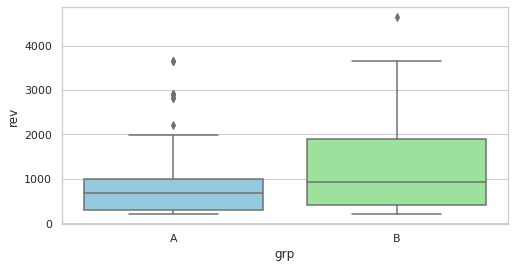

In [22]:
# построим диаграмму боксплот по всем пользователям, разделив значения по группам

sns.boxplot(data=users.query("rev>0"), x='grp', y='rev', palette=['skyblue', 'lightgreen'])

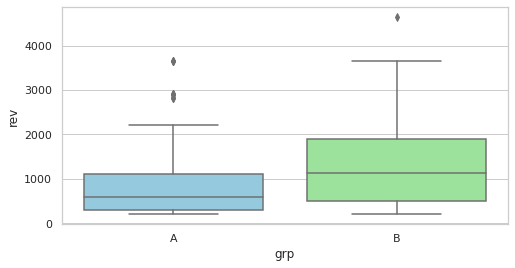

In [23]:
# построим диаграмму боксплот по активным пользователям, разделив значения по группам

sns.boxplot(data=activ_users.query("rev>0"), x='grp', y='rev', palette=['skyblue', 'lightgreen'])

По диаграммам боксплот видно, что данные как по всем пользователям, так и по активным - имеют примерно одинаковые зависимости. В данных наблюдаются выбросы, при этом линия медианного значения в группе В проходит выше, значений группы А, примерно на уровне 25% для группы А. Размах по суммам покупок также значительно выше в группе В. Это говорит о том, что пользователи группы В делали большее количество покупок, соответственно, приносят больше прибыли, нежели пользователи группы А.

In [24]:
# смотрим Conversion Rate (конверсию) у активных пользователей

#users.buy.value_counts(normalize=True).mul(100)     # соотношение по всем пользователям

activ_users.buy.value_counts(normalize=True).mul(100)

not_buy    95.300324
buy         4.699676
Name: buy, dtype: float64

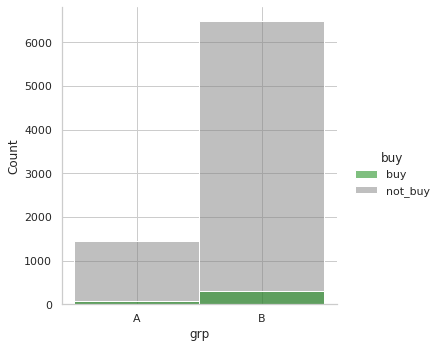

In [25]:
# построим диаграмму и посмотрим визуально на различия среди активных пользователей

sns.displot(data=activ_users[['buy', 'grp']].dropna(), x="grp", hue="buy", bins=2, palette=['green', 'grey'])
sns.despine()

Визуально можно видеть различия групп, которые, возможно, обусловлены различным соотношением числа пользователей в группах. Проверим показатель конверсии с помощью статистического теста.


**Проверка гипотез с помощью статистических тестов**  

Мы имеем две категориальные переменные _buy и grp_. Поэтому для проверки конверсии можно воспользоваться критерием **Хи-квадрат**.

Мы имеем две гипотезы:

- **𝐻0**: статистических различий между группами в конверсии нет
- **𝐻1**: статистические различия между группами в конверсии присутствуют

In [26]:
# создадим своднную таблицу по количеству пользователей в двух группах и как менялась конверсия в покупку

tab1 = pd.crosstab(users.buy, users.grp)                # по всем пользователям
tab2 = pd.crosstab(activ_users.buy, activ_users.grp)    # по активным пользователям

tab_concat = pd.concat([tab1, tab2])

tab_concat

grp,A,B
buy,,
buy,107,434
not_buy,14586,59449
buy,78,314
not_buy,1460,6489


In [27]:
# считаем статистику и p-value с помощью Хи-квадрат (берем только по активным пользователям)

stat, p, dof, expected = chi2_contingency(tab2)
stat, p

(0.484808265225579, 0.48625240457231034)

In [28]:
# Интерпретируем результат:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [29]:
# проверим с помощью модуля пингвин

exp, obs, stats = pg.chi2_independence(data=activ_users, x="grp", y="buy")
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.484808,1.0,0.486252,0.007624,0.107123
1,cressie-read,0.666667,0.482018,1.0,0.487510,0.007602,0.106787
2,log-likelihood,0.000000,0.476541,1.0,0.489993,0.007559,0.106127
3,freeman-tukey,-0.500000,0.472522,1.0,0.491829,0.007527,0.105643
4,mod-log-likelihood,-1.000000,0.468578,1.0,0.493642,0.007495,0.105168
5,neyman,-2.000000,0.460909,1.0,0.497200,0.007434,0.104245


**_Вывод:_** В ходе проверки гипотезы с помощью метода Хи-квадрат было получено значение **_p-value = 0,486_**, что дает нам право **не отклонять нулевую гипотезу H0** об отсутствии статистически значимых различий. Проверка с помощью модуля пингвина дала аналогичный результат.

**Проверка данных по группам пользователей на нормальность распределения**

In [30]:
# разделим всех пользователей на группы и запишем в переменные:

group_a = users.query("grp == 'A'")                # все пользователи группы А
group_b = users.query("grp == 'B'")                # все пользователи группы B
activ_group_a = activ_users.query("grp == 'A'")    # активные пользователи группы А
activ_group_b = activ_users.query("grp == 'B'")    # активные пользователи группы B

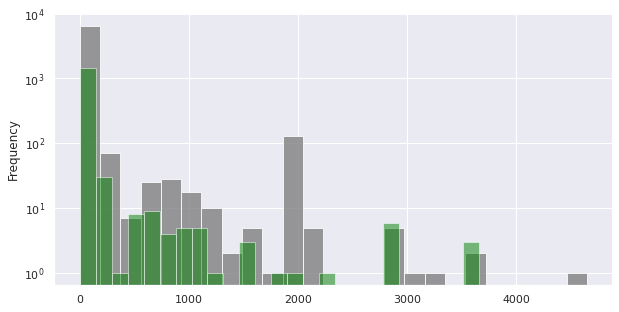

In [31]:
# построим диаграмму распределения значений двух групп

sns.set(rc={'figure.figsize':(10,5)})
activ_group_b.rev.plot(kind='hist', bins=25,  color='grey', alpha=0.8, logy=True)
activ_group_a.rev.plot(kind='hist', bins=25,  color='green', alpha=0.5, logy=True)
sns.despine()

In [32]:
# Группа A

shapiro_act_a = ss.shapiro(activ_group_a.rev)
print(f'тест Шапиро-Уилка по покупкам активных пользователей группы А: \n {shapiro_act_a}\n')

# Группа B

shapiro_act_b = ss.shapiro(activ_group_b.rev)
print(f'тест Шапиро-Уилка по покупкам активных пользователей группы B: \n {shapiro_act_b}')

тест Шапиро-Уилка по покупкам активных пользователей группы А: 
 ShapiroResult(statistic=0.1541670560836792, pvalue=0.0)

тест Шапиро-Уилка по покупкам активных пользователей группы B: 
 ShapiroResult(statistic=0.18124502897262573, pvalue=0.0)


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [33]:
#через pingouin

#pg.normality(data=activ_users, dv="rev", group="grp", method="normaltest")

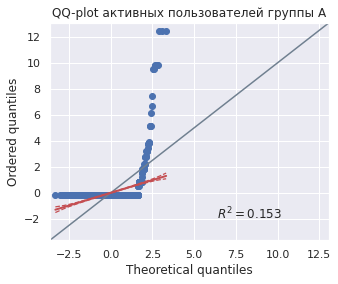

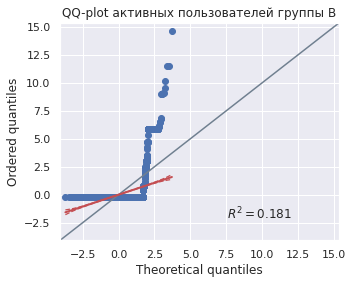

In [34]:
# построим qq-plot графики

ax1 = pg.qqplot(activ_group_a.rev).set_title('QQ-plot активных пользователей группы A')
ax2 = pg.qqplot(activ_group_b.rev).set_title('QQ-plot активных пользователей группы В')

**Вывод:** На основе проведенных тестов Шапиро-Уилка, а также методом qq-plot модуля pingouin мы видим, что распределение наблюдений по суммам покупок внутри групп **_не является нормальным_**, так как во всех случаях p-value имеет очень небольшое значение и существенно меньше 0,05. На графиках qq-plot наблюдается существенное отклонение. 

**Выбор метрик**  

Для дальнейшей проверки были выбраны и рассчитаны следующие метрики:

- конверсия - посмотрим конверсию в покупку среди всех пользователей (CR), и среди активных пользователей (CR_active);
- ARPU - отношение суммы выручки к общему количеству пользователей;
- ARPAU - отношение суммы выручки к общему количеству активных пользователей;
- ARPPU - отношение суммы выручки к общему количеству купивших пользователей;
- медианная сумма покупки пользователя.

Для начала произведем рассчеты этих метрик.

In [35]:
# рассчитаем конверсию из всех пользователей в купивших в группах А и В

CR_a = round(group_a.query("rev > 0").student_id.count() / group_a.student_id.count() * 100, 2)
CR_b = round(group_b.query("rev > 0").student_id.count() / group_b.student_id.count() * 100, 2)

print(f'Конверсия в покупку среди всех пользователей группы А: {CR_a}%\nКонверсия в покупку среди всех пользователей группы В: {CR_b}%')

Конверсия в покупку среди всех пользователей группы А: 0.73%
Конверсия в покупку среди всех пользователей группы В: 0.72%


In [36]:
# рассчитаем конверсию из активных пользователей в купивших в группах А и В

CR_active_a = round(activ_group_a.query("rev > 0").student_id.count() / activ_group_a.student_id.count() * 100, 2)
CR_active_b = round(activ_group_b.query("rev > 0").student_id.count() / activ_group_b.student_id.count() * 100, 2)

print(f'Конверсия в покупку среди активных пользователей группы А: {CR_active_a}%\nКонверсия в покупку среди активных пользователей группы В: {CR_active_b}%')

Конверсия в покупку среди активных пользователей группы А: 5.07%
Конверсия в покупку среди активных пользователей группы В: 4.62%


In [37]:
# рассчитаем среднюю стоимость покупки в группах А и В

mean_a = group_a.query("rev > 0").rev.mean()
mean_b = group_b.query("rev > 0").rev.mean()
print(f'Средняя стоимость покупки в группе А: {mean_a}\nСредняя стоимость покупки в группе В: {mean_b}')

Средняя стоимость покупки в группе А: 860.7102803738318
Средняя стоимость покупки в группе В: 1108.8248930875575


In [38]:
ARPU_a = round(group_a.rev.sum() / group_a.student_id.count(), 2)
ARPU_b = round(group_b.rev.sum() / group_b.student_id.count(), 2)
ARPAU_a = round(group_a.rev.sum() / activ_group_a.student_id.count(), 2)
ARPAU_b = round(group_b.rev.sum() / activ_group_b.student_id.count(), 2)
ARPPU_a = round(group_a.rev.sum() / group_a.query("rev>0").student_id.count(), 2) 
ARPPU_b = round(group_b.rev.sum() / group_b.query("rev>0").student_id.count(), 2)

In [39]:
# выведем полученные значения метрик

lst_metrics = [ARPU_a, ARPU_b, ARPAU_a, ARPAU_b, ARPPU_a, ARPPU_b]
metrics_name = ['ARPU_a', 'ARPU_b', 'ARPAU_a', 'ARPAU_b', 'ARPPU_a', 'ARPPU_b']
for i, с in enumerate(lst_metrics):
    print(f"{metrics_name[i]}: {lst_metrics[i]}")

ARPU_a: 6.27
ARPU_b: 8.04
ARPAU_a: 59.88
ARPAU_b: 70.74
ARPPU_a: 860.71
ARPPU_b: 1108.82


In [40]:
# создадаим таблицу с результирующими данными

res = pd.DataFrame({
        'group':       ['A', 'B'],
        'CR':          [CR_a, CR_b],
        'CR_active':   [CR_active_a, CR_active_b],
        'avg_cost':    [mean_a, mean_b],
        'ARPU':        [ARPU_a, ARPU_b],
        'ARPAU':       [ARPAU_a, ARPAU_b],
        'ARPPU':       [ARPPU_a, ARPPU_b]})
    
res.set_index('group', inplace=True)
res

,CR,CR_active,avg_cost,ARPU,ARPAU,ARPPU
group,,,,,,
A,0.73,5.07,860.710280,6.27,59.88,860.71
B,0.72,4.62,1108.824893,8.04,70.74,1108.82


Поскольку АБ-тестирование проводится по механике оплаты, то проверять будем только метрики, связанные с оплатой:
- **CR_active**: конверсию смотрим только из активных пользователей в купивших;
- **ARPAU**: средний доход с активного пользователя;
- **ARPPU**: средний доход с платящего пользователя.


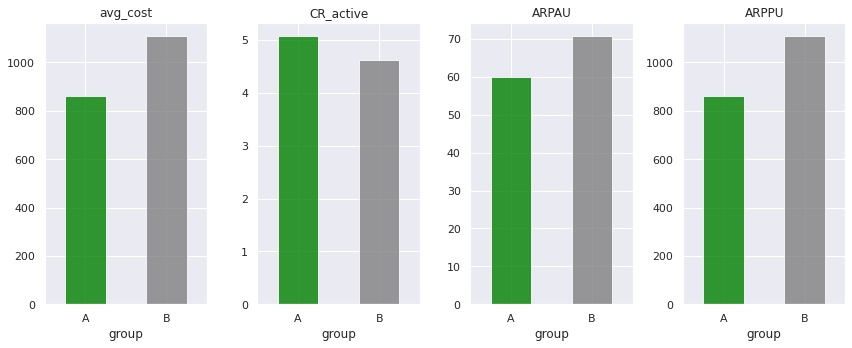

In [41]:
# визуализируем изменение выбранных метрик

fig, axes = plt.subplots(ncols=4, figsize=(12, 5))
for i, metric in enumerate(['avg_cost', 'CR_active', 'ARPAU', 'ARPPU']):
    res[metric].plot(kind='bar', ax=axes[i], rot=0,  alpha=0.8, color=['green', 'grey'])
    axes[i].set_title(f'{metric}')
plt.tight_layout()
plt.show()

**Вывод:** из приведенных выше графиков видно, что выбранные метрики меняются в зависимости от тестовой группы пользователя.  
Средняя стоимость покупки  пользователя (равна ARPPU) существенно выше в группе В. Также в тестовой группе В увеличились метрики ARPAU - средний доход с активного пользователя и ARPPU - средний доход с платящих пользователей. При этом наблюдается снижение показателя конверсии в покупку среди активных пользователей CR_active. Получается, что пользователей покупающих относительно обычных в группе В стало меньше, но сумма покупок у каждого пользователя увеличилась, по сравнению с группой А.    
Таким образом, из именющихся данных пока не понятно, стоит ли запускать новую механику оплаты на всех пользователей.  
Далее проверим, являются эти различия в группах статистически значимыми. 

**Проверка методом бутстрап**

Выбранные метрики  **_ARPAU и ARPPU_** проверим с помощью статистических тестов.  
Поскольку данные распределены не нормально, необходимо использовать непараметрические тесты.  
Выбираем один из таких тестов - метод бутстрап, для подсчета доверительного интервала и проверки p-value разности между двумя группами пользователей.  

In [42]:
res

,CR,CR_active,avg_cost,ARPU,ARPAU,ARPPU
group,,,,,,
A,0.73,5.07,860.710280,6.27,59.88,860.71
B,0.72,4.62,1108.824893,8.04,70.74,1108.82


In [43]:
# напишем функцию для бутстрапа и визуализации доверительных интервалов

def get_bootstrap(control,                            # значения контрольной выборки
                  test,                               # значения тестовой выборки
                  n = 10000,                          # количество подвыборок
                  statistic = np.mean,                # статистика - среднее
                  metric='x'):    
        len_data = max([len(control), len(test)])
        boot_data = []        
        
        print("\033[1mГипотезы:\033[0m")
        print(f"\033[1mH0:\033[0m {metric} в двух группах одинаковые")
        print(f"\033[1mH1:\033[0m {metric} в двух группах различаются")
        

        for i in (range(n)):                                                      # извлекаем подвыборки
            sample1 = control.sample(len_data, replace = True).values     
            sample2 = test.sample(len_data, replace = True).values

            samples_delta = sample2 - sample1                                      # находим разницу подвыборок
            boot_data.append(statistic(samples_delta))                             # применяем статистику для разниц подвыборок

        boot_df = pd.DataFrame(boot_data)

        # устанавливаем доверительный интервал 
        left_q = (1 - 0.95) / 2                    # левая граница
        right_q = 1 - (1 - 0.95) / 2               # правая граница
        ci = boot_df.quantile([left_q, right_q])

        p1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
        p2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
        p_value = min(p1, p2) * 2                   # p-значение для разности между двумя выборками

        # рисуем график
        plt.hist(boot_df[0], bins = 50, color='tan', edgecolor='gray')
        plt.vlines(ci, ymin=0, ymax=250, color='red', linestyle='--')
        plt.title(f"{metric}")        
        plt.show()    
        
        metric_res = {"ci - границы доверительного интервала": ci, "p_value": p_value}
     
        # проверка гипотезы     
        if metric_res['p_value'] < 0.05:
            print("Гипотеза H0 отвергается в пользу альтернативной гипотезы H1\n")
        else:
            print("Гипотеза H0 не отвергается\n")
        
        # вывод результатов
        print(f"\033[1m{metric}\033[0m")
        return metric_res 

In [44]:
# для метрики ARPU

#arpu_res = get_bootstrap(users.query("grp == 'A' and rev>0").rev, users.query("grp == 'B' and rev>0").rev, metric='ARPU')
#arpu_res

Гипотезы:
H0: ARPAU в двух группах одинаковые
H1: ARPAU в двух группах различаются


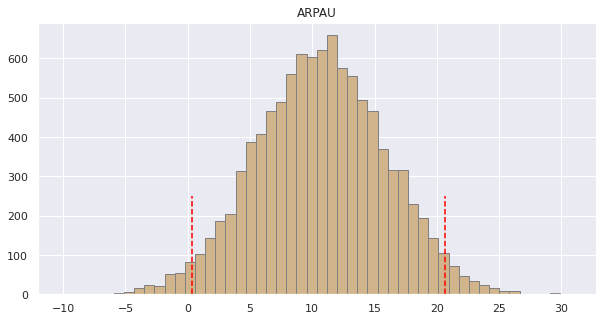

Гипотеза H0 отвергается в пользу альтернативной гипотезы H1

ARPAU


{'ci - границы доверительного интервала':                0
 0.025   0.382718
 0.975  20.633258,
 'p_value': 0.039571488099012744}

In [45]:
# для метрики ARPAU

arpau_res = get_bootstrap(activ_group_a.rev, activ_group_b.rev, metric='ARPAU')
arpau_res

Гипотезы:
H0: ARPPU в двух группах одинаковые
H1: ARPPU в двух группах различаются


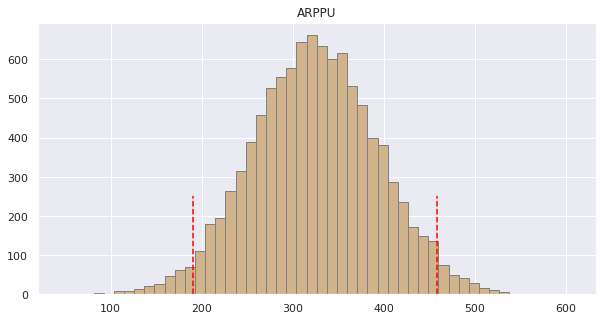

Гипотеза H0 отвергается в пользу альтернативной гипотезы H1

ARPPU


{'ci - границы доверительного интервала':                 0
 0.025  190.039897
 0.975  458.341014,
 'p_value': 2.344808093760201e-06}

In [46]:
# для метрики ARPPU

arppu_res = get_bootstrap(activ_users.query("grp == 'A' and rev>0").rev, activ_users.query("grp == 'B' and rev>0").rev, metric='ARPPU')
arppu_res

**Выводы:** Проведя проверку методом бутстрапа для метрик ARPAU, ARPРU видим, что доверительные интервалы всех трех метрик не пересекают нуллевые значения. При этом, метрика ARPAU имеет левую границу близко расположенную к 0 значению, но все же при многократном повторе также, как и две другие метрики ее не пересекает.  

Таким образом, гипотеза **_Н0_** - отклоняется во всех случаях в пользу **_Н1_**, которая говорит об **_имеющихся статистически значимых различиях_** в тестовой и контрольной группах пользователей. При этом, изменения механики оплаты смогли повлиять на общее увеличение выручки. И, учитывая факт, что значение конверсии изменилось не настолько сильно в группе В, я считаю, что следует попробовать запустить новую механику оплаты на всех пользователей. Но возможно, в будущем стоит повторить АБ-тест через какое-то время, при этом сделав выборки групп более равномерными и не сильно отличающимися по размеру.  

### Задание 2.  SQL
_____
**2.1 Очень усердные ученики.**   

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".  
Назовём очень усердным учеником того пользователя, который **_хотя бы раз за текущий месяц правильно решил 20 горошин._**  
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.  
**NB!** Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.  

**_Данные:_**  в таблице _default.peas_   

|Название атрибута |Тип атрибута |Смысловое значение |
|:-----------------|:------------|:------------------|
|st_id |int |ID ученика |
|timest |timestamp |Время решения карточки |
|correct |bool |Правильно ли решена горошина? |
|subject |text	|Дисциплина, в которой находится горошина |  


In [47]:
#импортируем нужные библиотеки
import pandahouse as ph
import pandas as pd


# объявляем параметры подключения (создаем словарь `connection`, задавая параметры для подключения к default:)

connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [48]:
# проверяем сколько месяцев 

query_month = """
SELECT distinct(date_trunc('month', timest)) 
FROM default.peas; 
"""
df_month = ph.read_clickhouse(query_month, connection=connection_default)
df_month

,"date_trunc(\'month\', timest)"
0,2021-10-01


Видим, что в данной таблице присутсвуют данные только по одному месяцу (октябрь).  

Теперь посмотрим количество задач, правильно решенных каждым учеником и отсортируем только тех, кто решил 20 и более задач.

In [49]:
# количество правильно решенных задач каждым учеником

query_tasks = """
SELECT st_id, count(correct) 
FROM default.peas
WHERE correct == TRUE
GROUP BY st_id, DATE_TRUNC('month', timest)
HAVING sum(correct)>=20;  
"""
df_tasks = ph.read_clickhouse(query_tasks, connection=connection_default)
df_tasks.head()

,st_id,count(correct)
0,510283,23
1,370846,34
2,43985,28
3,335446,45
4,899745,45


In [50]:
# с помощью вложенного запроса найдем общее количество усердных учеников

query_peas = """               
SELECT count(DISTINCT st_id) AS num_stud
FROM (
    SELECT st_id, count(correct) 
    FROM default.peas
    WHERE correct == TRUE
    GROUP BY st_id, DATE_TRUNC('month', timest)
    HAVING sum(correct)>=20);
"""
df_peas = ph.read_clickhouse(query_peas, connection=connection_default)
df_peas

,num_stud
0,136


Всего 136 очень усердных учеников.  

______
    
**2.2 Оптимизация воронки**  

**Условие**  

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.  

**_Данные:_**  

- таблица default.peas (данные выше)
- таблица default.studs

| Название атрибута | Тип атрибута | Смысловое значение | 
| :----------- | :----------- |:----------- | 
| st_id   | int   | ID ученика | 
| test_grp   | text   | Метка ученика в данном эксперименте | 


- таблица default.final_project_check

| Название атрибута | Тип атрибута | Смысловое значение | 
| :----------- | :----------- |:----------- | 
|st_id  | int | ID ученика |
| sale_time | timestamp | Время покупки |
|money  |int  | Цена, по которой приобрели данный курс |
|subject  | text |  |  
	 	
**_Что найти:_**  
в одном запросе выгрузить следующую информацию о группах пользователей:
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

**ARPU** считается относительно всех пользователей, попавших в группы.  
Активным считается пользователь, за все время решивший **_больше 10 задач правильно в любых дисциплинах._**  
Активным по математике считается пользователь, за все время решивший **_2 или больше задач правильно по математике._**  

Распишем все метрики, что чем является:  
- **ARPU (Average Revenue Per User )** - отношение выручки к общему количеству пользователей: сумма доходов по всем студентам, деленная на количество уникальных студентов 
- **ARPAU (Average Revenue Per Active User)** - отношение выручки к количеству активных пользователей: сумма доходов только от активных студентов, деленная на количество уникальных активных студентов
- **CR в покупку** - отношение количества купивших пользователей к общему количеству пользователей: количество купивших студентов, деленная на количество уникальных студентов
- **СR активного пользователя в покупку** - отношение количества купивших активных пользователей к общему количеству активных пользователей:  количество купивших активных студентов, деленная на количество уникальных активных студентов
- **CR пользователя из активности по математике в покупку курса по математике** - отношение количества купивших активных в математике студентов к общему количеству активных в математике студентов (subject = "math").  


In [51]:
# метрики ARPU и CR пользователей  можно посчитать в одном запросе, пишем запрос

query_arpu_cr = """
SELECT
      test_grp,
      SUM(f.money) / uniqExact(s.st_id) AS ARPU,
      COUNT(DISTINCT f.st_id) / COUNT(DISTINCT s.st_id) AS CR
FROM
    default.studs s 
    LEFT JOIN default.final_project_check f ON s.st_id = f.st_id
GROUP BY test_grp

"""
# записываем результат в пандасовский датафрейм
df_arpu_cr = ph.read_clickhouse(query_arpu_cr, connection=connection_default)  
df_arpu_cr

,test_grp,ARPU,CR
0,control,4540.983607,0.052459
1,pilot,11508.474576,0.111864


In [52]:
# теперь считаем метрику ARPAU

query_arpau = """
SELECT
      test_grp,
      SUM(f.money) / uniqExact(s.st_id) AS ARPAU
FROM
    default.studs s 
    LEFT JOIN default.final_project_check f ON s.st_id = f.st_id    
WHERE s.st_id in 
                (
                SELECT st_id
                FROM default.peas
                WHERE correct = 1
                GROUP BY st_id
                HAVING  COUNT(correct) > 10
                )   
GROUP BY test_grp
"""
# записываем результат в пандасовский датафрейм
df_arpau = ph.read_clickhouse(query_arpau, connection=connection_default)  
df_arpau

,test_grp,ARPAU
0,control,10393.700787
1,pilot,29739.583333


In [53]:
# считаем CR_active, конверсию из активного пользователя в покупку

query_cr_active = """
SELECT
    test_grp,
    COUNT(DISTINCT CASE 
                    WHEN f.money > 0 THEN f.st_id 
                    END) / COUNT(DISTINCT s.st_id) AS CR_active
FROM
    default.studs s 
    LEFT JOIN default.final_project_check f ON s.st_id = f.st_id
WHERE s.st_id IN 
    (
        SELECT st_id
        FROM default.peas
        WHERE correct = 1
        GROUP BY st_id
        HAVING COUNT(correct) > 10
    )  
GROUP BY test_grp;

"""
# записываем результат в пандасовский датафрейм
df_cr_active = ph.read_clickhouse(query_cr_active, connection=connection_default)  
df_cr_active

,test_grp,CR_active
0,control,0.110236
1,pilot,0.260417


In [54]:
# добавляем условия и подобным образом считаем CR_math

query_cr_math = """
SELECT
    test_grp,
    COUNT(DISTINCT CASE WHEN f.money > 0 AND subject = 'Math' THEN f.st_id END) / COUNT(DISTINCT s.st_id) AS CR_math
FROM
    default.studs s 
LEFT JOIN default.final_project_check f ON s.st_id = f.st_id
WHERE s.st_id IN 
    (
        SELECT st_id
        FROM default.peas
        WHERE correct = 1
        AND subject = 'Math'
        GROUP BY st_id
        HAVING COUNT(correct) >= 2
    )  
GROUP BY test_grp;

"""
# записываем результат в пандасовский датафрейм
df_cr_math = ph.read_clickhouse(query_cr_math, connection=connection_default)  
df_cr_math

,test_grp,CR_math
0,control,0.061224
1,pilot,0.095238


Мы получили все метрики по отдельности, теперь их нужно объединить в один запрос, чтобы все метрики по каждой группе отображались в одной табличке.

In [55]:
# соединяем в один запрос (с помощью WITH) и получаем итоговый, который нам выводит итоговую таблицу

query_itog = """                         
WITH 
active_st AS
    ( -- активные
    SELECT st_id
    FROM default.peas
    WHERE correct = 1
    GROUP BY st_id
    HAVING  COUNT(correct) > 10
    ),
math_st AS
    ( -- активные по Математике
    SELECT st_id
    FROM default.peas
    WHERE correct = 1 AND subject = 'Math'
    GROUP BY st_id
    HAVING COUNT(correct) >= 2 
    ),
act_buy_st AS
    ( -- активные, которые купили
    SELECT p.st_id
    FROM default.peas p
    LEFT JOIN default.final_project_check f ON p.st_id = f.st_id
    WHERE correct = 1 AND f.money>0
    GROUP BY p.st_id
    HAVING  COUNT(correct) > 10 
    )                                       
SELECT
      s.test_grp AS test_group,
      SUM(f.money) / uniqExact(s.st_id) AS ARPU,
      SUM(a.money) / uniqExact(a.st_id) AS ARPAU,  
      COUNT(DISTINCT f.st_id) / COUNT(DISTINCT s.st_id) AS CR,
      COUNT(DISTINCT CASE 
                    WHEN f.money > 0 THEN b.st_id 
                    END) / COUNT(DISTINCT a.st_id) AS CR_active,
      COUNT(DISTINCT CASE 
                    WHEN f.money > 0 AND subject = 'Math' THEN m.st_id 
                    END) / COUNT(DISTINCT m.st_id) AS CR_math  
FROM
    default.studs s 
    LEFT JOIN default.final_project_check f ON s.st_id = f.st_id
    
    LEFT JOIN active_st a ON s.st_id = a.st_id
    LEFT JOIN act_buy_st b ON s.st_id = b.st_id
    LEFT JOIN math_st m ON s.st_id = m.st_id

GROUP BY s.test_grp

"""
df_itog = ph.read_clickhouse(query_itog, connection=connection_default)
df_itog

,test_group,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.983607,10820.3125,0.052459,0.117188,0.080000
1,pilot,11508.474576,35000.0000,0.111864,0.278351,0.116279


Получили все показатели, теперь приведем их к нормальному виду, ARPU и ARPAU округлим до целого числа, а метрики конверсий - отобразим в процентах с точностью до сотых.

In [56]:
def convert(x):
    x[['ARPU', 'ARPAU']] = round(x[['ARPU', 'ARPAU']])
    x[['CR', 'CR_active', 'CR_math']] = round(x[['CR', 'CR_active', 'CR_math']]*100)
    x[['CR', 'CR_active', 'CR_math']] = x[['CR', 'CR_active', 'CR_math']].astype(str) + '%'
    #x.style.set_caption('Group Metrics')
    return x

group_metrics = convert(df_itog)
group_metrics

,test_group,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4541.0,10820.0,5.0%,12.0%,8.0%
1,pilot,11508.0,35000.0,11.0%,28.0%,12.0%


**Вывод:**  Получили итоговую таблицу с показателями ARPU, ARPAU, CR, CR_active, CR_math.  
Видно, что в тестовой группе pilot - все показатели увеличились, по сравнению с показателями контрольной группы в два и более раза. В результате проведенного эксперимента можно заключить, что новый экран оплаты положительно влияет как на конверсию, так и на выручку с каждого пользователя. 


### Задание 3. Python

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.  

In [57]:
# напишем функцию, выводящую таблицу с итоговыми результатами метрик

def count_metrics(df, link):
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    group_add_df  = pd.read_csv(requests.get(base_url + urlencode(dict(public_key=link))).json()['href'])
    group_add_df.rename(columns=({group_add_df.columns[0]:'id', group_add_df.columns[1]:'grp'}), inplace=True)
    
    # Объединение файлов по столбцу 'id'
    
    #users_df = pd.concat([df, group_add_df], ignore_index=True)#.rename(columns={'id':'student_id'})
    users_df = pd.merge(df, group_add_df, on=['id', 'grp'], how='left')
    
    # объединим полученные данные с данными датасета checks
    
    users = pd.merge(users_df, checks.rename(columns={'student_id':'id'}), on='id', how='left').fillna(0)
    activ_users = users.merge(activ_stud.rename(columns={'student_id':'id'}), how='inner', on='id')
    
    # добавим столбец совершена ли покупка в день эксперимента
    users['buy']       = users.rev.apply(lambda x: 'buy' if x > 0 else 'not_buy')
    activ_users['buy'] = activ_users.rev.apply(lambda x: 'buy' if x > 0 else 'not_buy')
    
    
    # разделим всех пользователей на группы:
    group_a = users.query("grp == 'A'")                # все пользователи группы А
    group_b = users.query("grp == 'B'")                # все пользователи группы B
    activ_group_a = activ_users.query("grp == 'A'")    # активные пользователи группы А
    activ_group_b = activ_users.query("grp == 'B'")    # активные пользователи группы B

    # рассчет метрики медианной стоимости покупки в группах А и В
    #median_a = group_a.query("rev > 0").rev.median()
    #median_b = group_b.query("rev > 0").rev.median()
    #print(f'Медианная стоимость покупки в группе А: {median_a}\nМедианная стоимость покупки в группе В: {median_b}')

    # рассчет конверсии из всех пользователей в купивших в группах А и В
    CR_a = round(group_a.query("rev > 0").id.count() / group_a.id.count() * 100, 2)
    CR_b = round(group_b.query("rev > 0").id.count() / group_b.id.count() * 100, 2)
    print(f'Конверсия в покупку среди всех пользователей группы А: {CR_a}%\nКонверсия в покупку среди всех пользователей группы В: {CR_b}%')
    
    # рассчет конверсии из активных пользователей в купивших в группах А и В
    CR_active_a = round(activ_group_a.query("rev > 0").id.count() / activ_group_a.id.count() * 100, 2)
    CR_active_b = round(activ_group_b.query("rev > 0").id.count() / activ_group_b.id.count() * 100, 2)
    print(f'Конверсия в покупку среди активных пользователей группы А: {CR_active_a}%\nКонверсия в покупку среди активных пользователей группы В: {CR_active_b}%')

    # рассчет метрик ARPU, ARPAU, ARPPU
    ARPU_a = round(group_a.rev.sum() / group_a.id.count(), 2)
    ARPU_b = round(group_b.rev.sum() / group_b.id.count(), 2)
    ARPAU_a = round(group_a.rev.sum() / activ_group_a.id.count(), 2)
    ARPAU_b = round(group_b.rev.sum() / activ_group_b.id.count(), 2)
    ARPPU_a = round(group_a.rev.sum() / group_a.query("rev>0").id.count(), 2) 
    ARPPU_b = round(group_b.rev.sum() / group_b.query("rev>0").id.count(), 2)
    
    # создаем таблицу с результирующими данными
    res = pd.DataFrame({
            'group':       ['A', 'B'],
            'CR':          [CR_a, CR_b],
            'CR_active':   [CR_active_a, CR_active_b],
            #'median_cost': [median_a, median_b],
            'ARPU':        [ARPU_a, ARPU_b],
            'ARPAU':       [ARPAU_a, ARPAU_b],
            'ARPPU':       [ARPPU_a, ARPPU_b]})
    res.set_index('group', inplace=True)
    
    # делаем оформление итоговой таблицы
    res_style = (res.style.set_caption('Изменение метрик в контрольной и тестовой группах')
                          .highlight_max(axis='index')    # отметим цветом значения в группе, которые больше
                          .format({'CR': '{:.2f}', 
                                 'CR_active': '{:.2f}', 
                                 'ARPU': '{:.2f}', 
                                 'ARPAU': '{:.2f}',
                                 #'median_cost':"{:0<4.0f}",
                                 'ARPPU':"{:0<4.0f}"})
                )
    
    return res_style

In [58]:
# задаем параметры функции
result_table = count_metrics(df = groups, link ='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')

# выведем результат функции
result_table

Конверсия в покупку среди всех пользователей группы А: 0.73%
Конверсия в покупку среди всех пользователей группы В: 0.72%
Конверсия в покупку среди активных пользователей группы А: 5.08%
Конверсия в покупку среди активных пользователей группы В: 4.61%


,CR,CR_active,ARPU,ARPAU,ARPPU
group,,,,,
A,0.73,5.08,6.28,60.00,8610
B,0.72,4.61,8.01,70.56,1107



___
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.  

In [59]:
# напишем функцию, отображающую визуализацию по рассчитанным метрикам

def get_visual(df):
    
    # формируем блок из 6 графиков
    fig, axes = plt.subplots(ncols=5, figsize=(18, 5))
    
    # заголовок
    fig.suptitle('Изменение метрик по группам', fontsize=20)
    
    # выводим графики по всем метрикам
    lst_metric = ['CR', 'CR_active', 'ARPU', 'ARPAU', 'ARPPU']
    
    for i, metric in enumerate(lst_metric):
        df[metric].plot(kind='bar', ax=axes[i], rot=0,  alpha=0.8, color=['green', 'grey'])
        axes[i].set_xlabel(f'{metric}')
    plt.tight_layout()
    plt.show()
    return df

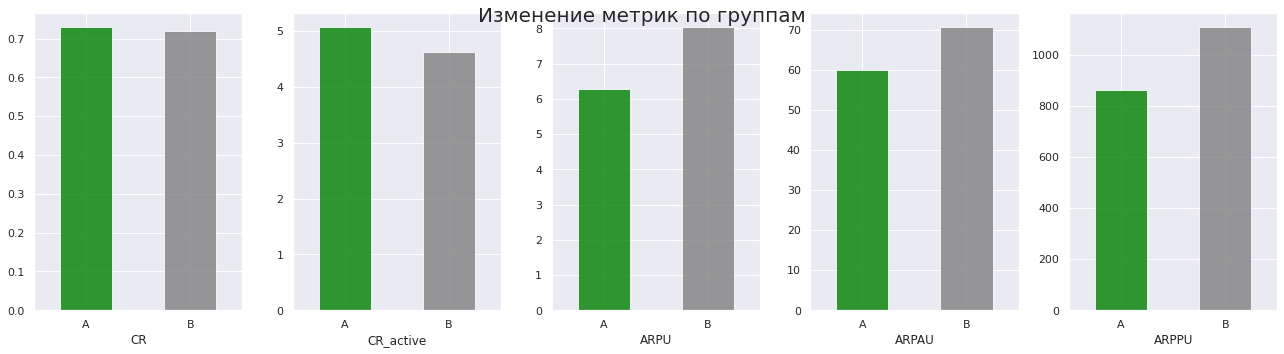

,CR,CR_active,avg_cost,ARPU,ARPAU,ARPPU
group,,,,,,
A,0.73,5.07,860.710280,6.27,59.88,860.71
B,0.72,4.62,1108.824893,8.04,70.74,1108.82


In [60]:
# задаем параметры функции
get_visual(res)

С помощью функций **_count_metrics(df, link)_** и **_get_visual(df)_** по заданным параметрам (датафрейм и ссылка на данные) были получены итоговое отображение всех рассчитанных метрик. Все метрики представлены для удобства в виде таблицы. А также получено визуальное отображение изменения данных метрик по группам А и В.